<a href="https://colab.research.google.com/github/florivz/DDM-Project-WS24-25/blob/main/analysis_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!git clone https://github.com/florivz/DDM-Project-WS24-25.git

Cloning into 'DDM-Project-WS24-25'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 56 (delta 26), reused 15 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (56/56), 34.00 MiB | 16.41 MiB/s, done.
Resolving deltas: 100% (26/26), done.
Updating files: 100% (12/12), done.


In [7]:
import pandas as pd
import os
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from google.colab import userdata
from sklearn.cluster import KMeans
from matplotlib.patches import Patch
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import TruncatedSVD

# Loading the Data

In [8]:
pkl_path = 'DDM-Project-WS24-25/pkl/'

In [9]:
df_gdp = pd.read_pickle(pkl_path + "gdp.pickle")
df_pattern = pd.read_pickle(pkl_path + "naics_pattern.pickle")
df_occupation_1 = pd.read_pickle(pkl_path + "naics_occupation_part1.pickle")
df_occupation_2 = pd.read_pickle(pkl_path + "naics_occupation_part2.pickle")
df_occupation_3 = pd.read_pickle(pkl_path + "naics_occupation_part3.pickle")
df_county = pd.read_pickle(pkl_path + "county.pickle")
df_state = pd.read_pickle(pkl_path + 'state.pickle')

# Cleaning the data

In [12]:
df_pattern['FIPS'] = df_pattern['FIPS'].astype(str)

def add_zeros(code):
    if len(code) == 3:
        return '00' + code
    elif len(code) == 4:
        return '0' + code
    elif len(code) == 1:
        return '0000' + code
    return code

df_pattern['FIPS'] = df_pattern['FIPS'].apply(add_zeros)

In [13]:
df_occupation = pd.concat([df_occupation_1, df_occupation_2, df_occupation_3], ignore_index=True)
df_occupation.head()

,FIPS,State_GEOID,naics,NAICS_TITLE,emp_total_county_naics,OCC_CODE,OCC_TITLE,emp_occupation,state_name
0,12999,12,5613,Employment Services,1436559,49-9071,"Maintenance and Repair Workers, General",20639.514235,NaN
1,06999,6,5613,Employment Services,729335,49-9071,"Maintenance and Repair Workers, General",9414.167765,NaN
2,36999,36,5613,Employment Services,308333,49-9071,"Maintenance and Repair Workers, General",8332.850279,NaN
3,06037,6,8111,Automotive Repair and Maintenance,25081,49-3023,Automotive Service Technicians and Mechanics,5913.423292,California
4,48999,48,5613,Employment Services,340926,49-9071,"Maintenance and Repair Workers, General",5770.378034,NaN


# Feature Selection

## Filtering & Aggregating the industries with most establishments per FIPS

In [24]:
df_top_industries = df_pattern.groupby(['naics', 'DESCRIPTION']).agg({
    'emp': 'sum',
    'est': 'sum',
    'FIPS': 'nunique'
}).reset_index()

df_top_industries = df_top_industries.sort_values(by=['est', 'emp'], ascending=False)

df_top_industries.head(40)

,naics,DESCRIPTION,emp,est,FIPS
65,5617,Services to Buildings and Dwellings,2004960,220492,2530
13,2382,Building Equipment Contractors,2171001,193562,2756
67,8111,Automotive Repair and Maintenance,902870,164584,2725
14,2383,Building Finishing Contractors,811812,124074,2040
62,5413,"Architectural, Engineering, and Related Services",1579218,115269,1924
12,2381,"Foundation, Structure, and Building Exterior C...",901696,101383,2313
66,7139,Other Amusement and Recreation Industries,1092894,76488,2182
54,4413,"Automotive Parts, Accessories, and Tire Stores",532828,58112,2427
64,5613,Employment Services,7061425,57057,1306
51,4238,"Machinery, Equipment, and Supplies Merchant Wh...",739134,54251,1947


## Ranking the Industries

In [34]:
tool_consumption_ranking = {
    11: 2,   # Agriculture, Forestry, Fishing and Hunting
    21: 1,   # Mining
    22: 3,   # Utilities
    23: 1,   # Construction
    31: 1,   # Manufacturing
    32: 1,   # Manufacturing
    33: 1,   # Manufacturing
    42: 10,   # Wholesale Trade
    44: 10,   # Retail Trade
    45: 10,   # Retail Trade
    48: 3,   # Transportation and Warehousing
    49: 3,   # Transportation and Warehousing
    51: 10,   # Information
    52: 10,   # Finance and Insurance
    53: 8,   # Real Estate Rental and Leasing
    54: 4,  # Professional, Scientific, and Technical Services
    55: 10,   # Management of Companies and Enterprises
    56: 6,   # Administrative and Support and Waste Services
    61: 9,   # Educational Services
    62: 7,   # Health Care and Social Assistance
    71: 6,   # Arts, Entertainment, and Recreation
    72: 4,   # Accommodation and Food Services
    81: 8,   # Other Services (except Public Administration)
    92: 10    # Public Administration
}

def get_ranking(naics_code):
    naics_prefix = int(str(naics_code)[:2])  # Die ersten zwei Ziffern extrahieren
    return tool_consumption_ranking.get(naics_prefix, None)  # Ranking aus dem Dictionary holen

# Neue Spalte 'ranking' zu deinem DataFrame hinzufügen
df_top_industries['tool_consumption'] = df_top_industries['naics'].apply(get_ranking).reset_index(drop=True)

df_top_industries.head(10)

,naics,DESCRIPTION,emp,est,FIPS,tool_consumption
65,5617,Services to Buildings and Dwellings,2004960,220492,2530,1
13,2382,Building Equipment Contractors,2171001,193562,2756,1
67,8111,Automotive Repair and Maintenance,902870,164584,2725,1
14,2383,Building Finishing Contractors,811812,124074,2040,1
62,5413,"Architectural, Engineering, and Related Services",1579218,115269,1924,1
12,2381,"Foundation, Structure, and Building Exterior C...",901696,101383,2313,10
66,7139,Other Amusement and Recreation Industries,1092894,76488,2182,1
54,4413,"Automotive Parts, Accessories, and Tire Stores",532828,58112,2427,3
64,5613,Employment Services,7061425,57057,1306,1
51,4238,"Machinery, Equipment, and Supplies Merchant Wh...",739134,54251,1947,1


In [33]:
df_top_industries['tool_consumption'].isna().sum()

0

In [35]:
df_top_industries['rank_est'] = pd.qcut(
    df_top_industries['est'].rank(ascending=False),  # Rankiere absteigend
    10,                                              # In 10 gleich große Gruppen aufteilen
    labels=range(1, 11)                              # Label von 1 (höchste) bis 10
)

# Ranking für die Spalte 'emp' von 1 bis 10
df_top_industries['rank_emp'] = pd.qcut(
    df_top_industries['emp'].rank(ascending=False),  # Rankiere absteigend
    10,                                              # In 10 gleich große Gruppen aufteilen
    labels=range(1, 11)                              # Label von 1 (höchste) bis 10
)

In [36]:
df_top_industries.head()

,naics,DESCRIPTION,emp,est,FIPS,tool_consumption,rank_est,rank_emp
65,5617,Services to Buildings and Dwellings,2004960,220492,2530,1,1,1
13,2382,Building Equipment Contractors,2171001,193562,2756,1,1,1
67,8111,Automotive Repair and Maintenance,902870,164584,2725,1,1,1
14,2383,Building Finishing Contractors,811812,124074,2040,1,1,2
62,5413,"Architectural, Engineering, and Related Services",1579218,115269,1924,1,1,1


In [39]:
# Gewichtungen definieren
weight_tool_consumption = 0.5
weight_emp = 0.3
weight_est = 0.2

# Berechnung der gewichteten Rankings
df_top_industries['weighted_rank'] = (
    df_top_industries['tool_consumption'].astype(float) * weight_tool_consumption +
    df_top_industries['rank_emp'].astype(float) * weight_emp +
    df_top_industries['rank_est'].astype(float) * weight_est
)

df_top_industries.sort_values(by='weighted_rank').head(30)

,naics,DESCRIPTION,emp,est,FIPS,tool_consumption,rank_est,rank_emp,weighted_rank
65,5617,Services to Buildings and Dwellings,2004960,220492,2530,1,1,1,1.0
13,2382,Building Equipment Contractors,2171001,193562,2756,1,1,1,1.0
67,8111,Automotive Repair and Maintenance,902870,164584,2725,1,1,1,1.0
62,5413,"Architectural, Engineering, and Related Services",1579218,115269,1924,1,1,1,1.0
66,7139,Other Amusement and Recreation Industries,1092894,76488,2182,1,1,1,1.0
64,5613,Employment Services,7061425,57057,1306,1,2,1,1.2
14,2383,Building Finishing Contractors,811812,124074,2040,1,1,2,1.3
51,4238,"Machinery, Equipment, and Supplies Merchant Wh...",739134,54251,1947,1,2,2,1.5
21,3231,Printing and Related Support Activities,356146,21376,1116,1,2,3,1.8
50,4231,Motor Vehicle and Motor Vehicle Parts and Supp...,390199,21491,1030,1,2,3,1.8


In [51]:
top_5_naics = df_top_industries.sort_values(by='weighted_rank').head(5)['naics'].tolist()
top_5_naics

['5617', '2382', '8111', '5413', '7139']

# Filtering the FIPS with the highest amount of Top Industries


In [53]:
feature_df = pd.DataFrame(df_pattern['FIPS'].unique(), columns=['FIPS'])

for naics_code in top_5_naics:
    est_values = df_pattern[df_pattern['naics'] == naics_code].groupby('FIPS')['est'].sum().reset_index()
    est_values.rename(columns={'est': f'est_{naics_code}'}, inplace=True)
    feature_df = feature_df.merge(est_values, on='FIPS', how='left')

feature_df.fillna(0, inplace=True)

feature_df.rename(columns={f'est_{naics}': f'est_{naics}' for naics in top_5_naics}, inplace=True)

feature_df.head()

,FIPS,est_5617,est_2382,est_8111,est_5413,est_7139
0,01001,30.0,27.0,20.0,7.0,12.0
1,01003,229.0,187.0,93.0,94.0,69.0
2,01005,8.0,7.0,10.0,7.0,4.0
3,01007,5.0,8.0,7.0,0.0,0.0
4,01009,19.0,37.0,20.0,3.0,7.0


# Data Preprocessing

In [55]:
df_final = feature_df.copy()

In [ ]:
len(df_final.drop_duplicates())

2637

In [56]:
# Impute Missing GDP with 0
df_final = df_final.dropna()

In [59]:
# Choosing relevant features
features = ['est_5617', 'est_2382', 'est_8111', 'est_5413', 'est_7139']
X = df_final[features]

In [60]:
# Scaling the data to make them comparable
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA

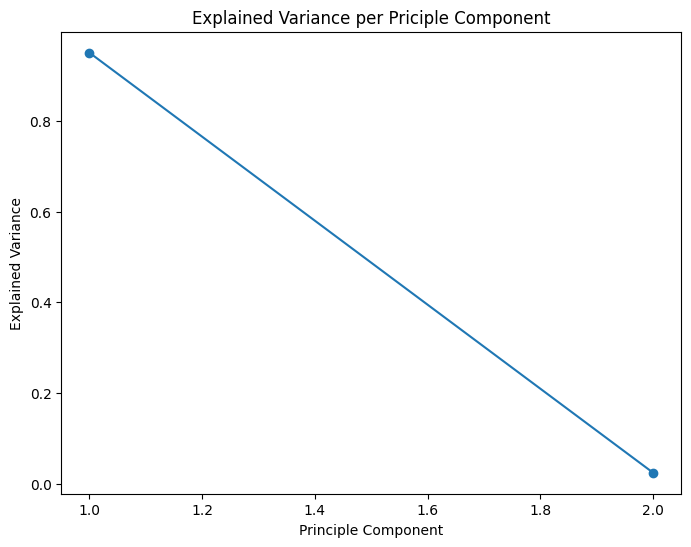

In [63]:
pca = PCA(n_components=2) # the elbow method showed 2 PC are best
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o')
plt.title('Explained Variance per Priciple Component')
plt.xlabel('Principle Component')
plt.ylabel('Explained Variance')
plt.show()

# Clustering

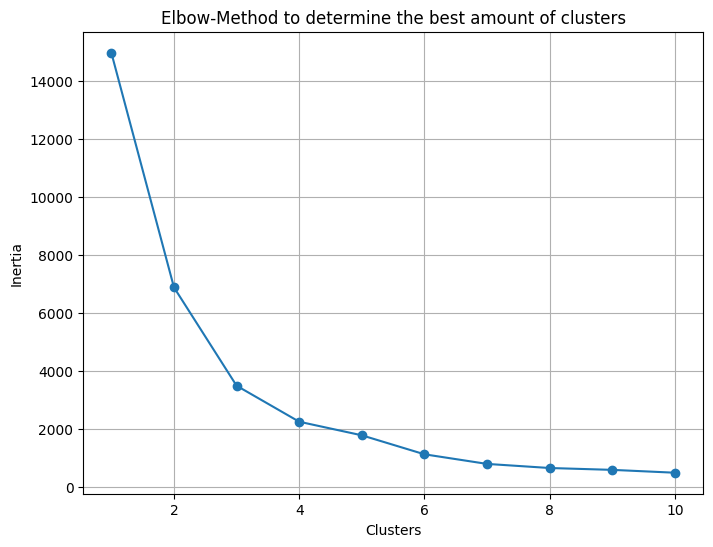

In [64]:
inertia = []
cluster_range = range(1, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

# Elbow-Method to visualize
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, inertia, marker='o')
plt.title('Elbow-Method to determine the best amount of clusters')
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


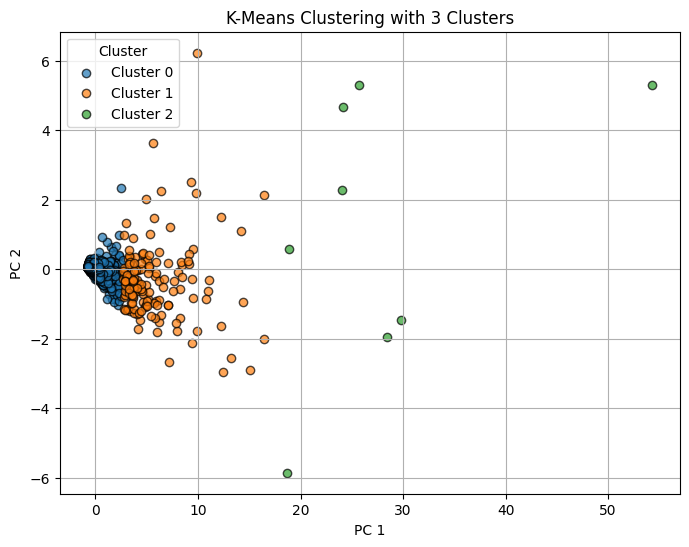

In [65]:
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_pca)
df_final['cluster'] = clusters

plt.figure(figsize=(8, 6))

for cluster_label in sorted(set(clusters)):
    plt.scatter(
        X_pca[clusters == cluster_label, 0],
        X_pca[clusters == cluster_label, 1],
        label=f'Cluster {cluster_label}',
        alpha=0.7,
        edgecolors='k'
    )

plt.title('K-Means Clustering with 3 Clusters')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

In [66]:
# 3d plotting

# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

# tsne_3d = TSNE(n_components=3, random_state=42, perplexity=30, n_iter=1000)
# X_tsne_3d = tsne_3d.fit_transform(X_pca)

# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')

# for cluster_label in sorted(set(clusters)):
#     ax.scatter(
#         X_tsne_3d[clusters == cluster_label, 0],
#         X_tsne_3d[clusters == cluster_label, 1],
#         X_tsne_3d[clusters == cluster_label, 2],
#         label=f'Cluster {cluster_label}',
#         alpha=0.7
#     )

# ax.set_title('3D t-SNE Visualization of Clusters')
# ax.set_xlabel('t-SNE 1')
# ax.set_ylabel('t-SNE 2')
# ax.set_zlabel('t-SNE 3')

# ax.legend(title='Cluster')
# plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


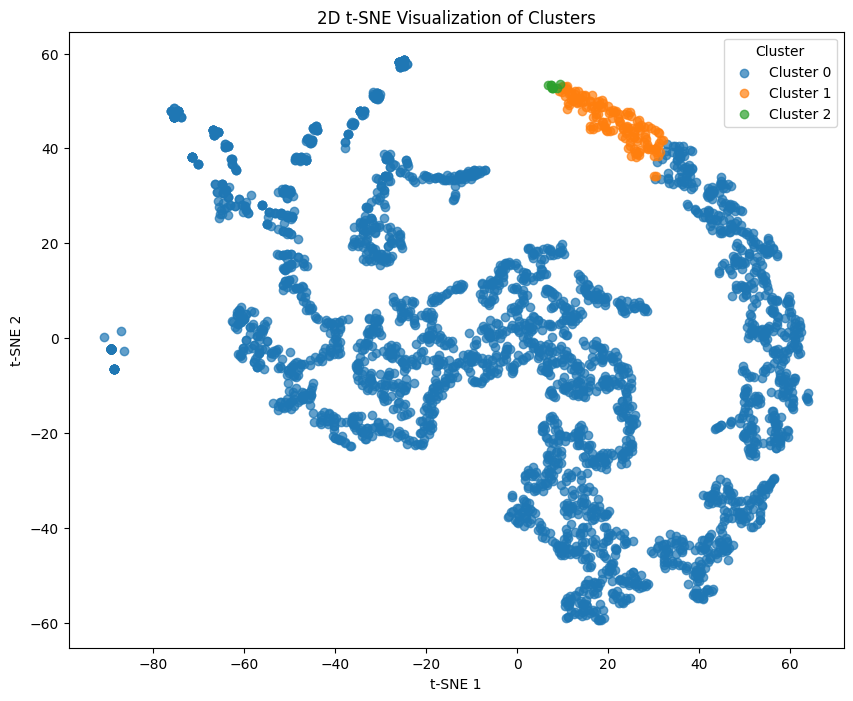

In [67]:
# 2d plotting
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne_2d = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne_2d = tsne_2d.fit_transform(X_pca)

plt.figure(figsize=(10, 8))

for cluster_label in sorted(set(clusters)):
    plt.scatter(
        X_tsne_2d[clusters == cluster_label, 0],
        X_tsne_2d[clusters == cluster_label, 1],
        label=f'Cluster {cluster_label}',
        alpha=0.7
    )

plt.title('2D t-SNE Visualization of Clusters')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(title='Cluster')
plt.show()


# Interpretation

In [68]:
df_final.head()

,FIPS,est_5617,est_2382,est_8111,est_5413,est_7139,cluster
0,01001,30.0,27.0,20.0,7.0,12.0,0
1,01003,229.0,187.0,93.0,94.0,69.0,0
2,01005,8.0,7.0,10.0,7.0,4.0,0
3,01007,5.0,8.0,7.0,0.0,0.0,0
4,01009,19.0,37.0,20.0,3.0,7.0,0


In [69]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3071 entries, 0 to 3070
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   FIPS      3071 non-null   object 
 1   est_5617  3071 non-null   float64
 2   est_2382  3071 non-null   float64
 3   est_8111  3071 non-null   float64
 4   est_5413  3071 non-null   float64
 5   est_7139  3071 non-null   float64
 6   cluster   3071 non-null   int32  
dtypes: float64(5), int32(1), object(1)
memory usage: 156.1+ KB


In [70]:
cluster_summary = (
    df_final.groupby('cluster')
    .agg(
        count=('cluster', 'size'),
        avg_ap=('ap', 'mean'),
        avg_est=('est', 'mean'),
        avg_emp=('emp', 'mean'),
        avg_current_gdp=('current_gdp', 'mean')
    )
    .reset_index()
)

print(cluster_summary)

KeyError: "Column(s) ['ap', 'current_gdp', 'emp', 'est'] do not exist"

In [71]:
df_result = df_final[(df_final['cluster'] == 0) | (df_final['cluster'] == 2)].reset_index(drop=True)
df_result.head()

,FIPS,est_5617,est_2382,est_8111,est_5413,est_7139,cluster
0,01001,30.0,27.0,20.0,7.0,12.0,0
1,01003,229.0,187.0,93.0,94.0,69.0,0
2,01005,8.0,7.0,10.0,7.0,4.0,0
3,01007,5.0,8.0,7.0,0.0,0.0,0
4,01009,19.0,37.0,20.0,3.0,7.0,0


# Visalization

In [72]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Merging GeoData with clusters
gdf_cluster = df_county.merge(df_result, left_on='GEOID', right_on='FIPS', how='inner')
gdf_cluster = gdf_cluster.groupby('FIPS').agg({
    'emp': 'sum',
    'est': 'sum',
    'current_gdp': 'sum'
}).sort_values(['emp',	'est',	'current_gdp'])
gdf_cluster.head()

scaled_values = scaler.fit_transform(gdf_cluster[['emp', 'est', 'current_gdp']])

gdf_cluster['scaled_emp'] = scaled_values[:, 0]
gdf_cluster['scaled_est'] = scaled_values[:, 1]
gdf_cluster['scaled_gdp'] = scaled_values[:, 2]

gdf_cluster['economic_importance'] = (
    gdf_cluster['scaled_emp'] * 0.5 +
    gdf_cluster['scaled_est'] * 0.3 +
    gdf_cluster['scaled_gdp'] * 0.2
)

gdf_cluster = gdf_cluster.sort_values(by='economic_importance', ascending=False)

gdf_cluster.head()

KeyError: "Column(s) ['current_gdp', 'emp', 'est'] do not exist"

In [73]:
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

gdf_county = gpd.GeoDataFrame(df_county, geometry='geometry')
gdf_states = gpd.GeoDataFrame(df_state, geometry='geometry')

gdf_county.crs = 'epsg:4269'
gdf_states.crs = 'epsg:4269'

non_contiguous_states = [
    'Alaska', 'Hawaii', 'Puerto Rico',
    'Commonwealth of the Northern Mariana Islands',
    'American Samoa', 'United States Virgin Islands', 'Guam'
]

filtered_states = gdf_states[~gdf_states['NAME'].isin(non_contiguous_states)]
filtered_statefps = filtered_states['STATEFP'].unique()
filtered_county = gdf_county[gdf_county['STATEFP'].isin(filtered_statefps)]

gdf_cluster = filtered_county.merge(df_result, left_on='GEOID', right_on='FIPS', how='inner')

scaler = MinMaxScaler()
gdf_cluster['economic_importance'] = scaler.fit_transform(
    gdf_cluster[['emp', 'est', 'current_gdp']]
).sum(axis=1)

gdf_cluster = gdf_cluster.to_crs('epsg:5070')
filtered_states = filtered_states.to_crs('epsg:5070')
filtered_county = filtered_county.to_crs('epsg:5070')

fig, ax = plt.subplots(figsize=(15, 7))

vmin = gdf_cluster['economic_importance'].min()
vmax = gdf_cluster['economic_importance'].max()

gdf_cluster.plot(
    column='economic_importance',
    cmap='OrRd',
    linewidth=0.8,
    ax=ax,
    edgecolor='0.8',
    legend=True,
    vmin=vmin,
    vmax=vmax
)

filtered_states.boundary.plot(ax=ax, color='black', linewidth=0.5)
filtered_county.boundary.plot(ax=ax, color='gray', linewidth=0.4, alpha=0.5)

ax.set_title('Counties with highest potential tool consumption', fontsize=16)
ax.set_axis_off()

plt.show()


KeyError: "None of [Index(['emp', 'est', 'current_gdp'], dtype='object')] are in the [columns]"

In [74]:
gdf_cluster.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,FIPS,est_5617,est_2382,est_8111,est_5413,est_7139,cluster
0,21,007,00516850,0500000US21007,21007,Ballard,06,639387454,69473325,"POLYGON ((-89.18137 37.0463, -89.17938 37.0530...",21007,5.0,3.0,4.0,4.0,0.0,0
1,21,017,00516855,0500000US21017,21017,Bourbon,06,750439351,4829777,"POLYGON ((-84.44266 38.28324, -84.44114 38.283...",21017,10.0,10.0,6.0,4.0,0.0,0
2,21,031,00516862,0500000US21031,21031,Butler,06,1103571974,13943044,"POLYGON ((-86.94486 37.07341, -86.94346 37.074...",21031,0.0,3.0,7.0,0.0,0.0,0
3,21,065,00516879,0500000US21065,21065,Estill,06,655509930,6516335,"POLYGON ((-84.12662 37.6454, -84.12483 37.6461...",21065,0.0,4.0,6.0,0.0,0.0,0
4,21,069,00516881,0500000US21069,21069,Fleming,06,902727151,7182793,"POLYGON ((-83.98428 38.44549, -83.98246 38.450...",21069,6.0,10.0,10.0,0.0,0.0,0


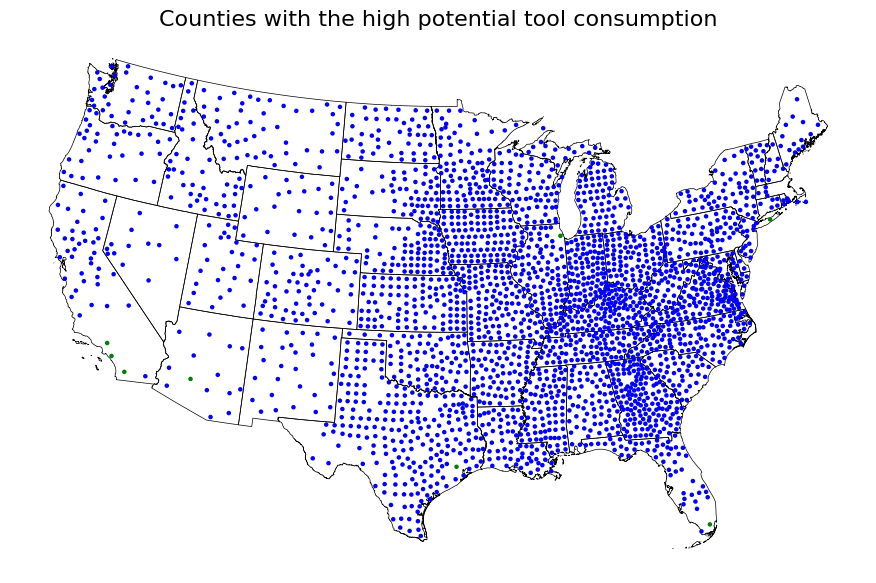

In [75]:
import geopandas as gpd
import matplotlib.pyplot as plt

gdf_county = gpd.GeoDataFrame(df_county, geometry='geometry')
gdf_states = gpd.GeoDataFrame(df_state, geometry='geometry')

gdf_county.crs = 'epsg:4269'
gdf_states.crs = 'epsg:4269'

# Exclude some states
non_contiguous_states = [
    'Alaska', 'Hawaii', 'Puerto Rico',
    'Commonwealth of the Northern Mariana Islands',
    'American Samoa', 'United States Virgin Islands', 'Guam'
]

filtered_states = gdf_states[~gdf_states['NAME'].isin(non_contiguous_states)]

filtered_statefps = filtered_states['STATEFP'].unique()

filtered_county = gdf_county[gdf_county['STATEFP'].isin(filtered_statefps)]

gdf_cluster = filtered_county.merge(df_result, left_on='GEOID', right_on='FIPS', how='inner')

gdf_cluster = gdf_cluster.to_crs('epsg:5070')
filtered_states = filtered_states.to_crs('epsg:5070')
filtered_county = filtered_county.to_crs('epsg:5070')

gdf_cluster['centroid'] = gdf_cluster.geometry.centroid

# Farben basierend auf dem Cluster
colors = gdf_cluster['cluster'].map({0: 'blue', 2: 'green'})

fig, ax = plt.subplots(figsize=(15, 7))

# Hintergrund mit Staaten
filtered_states.plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)

# Cluster mit Farben visualisieren
gdf_cluster.set_geometry('centroid').plot(ax=ax, color=colors, markersize=5)

ax.set_title('Counties with the high potential tool consumption', fontsize=16)
ax.set_axis_off()

plt.show()


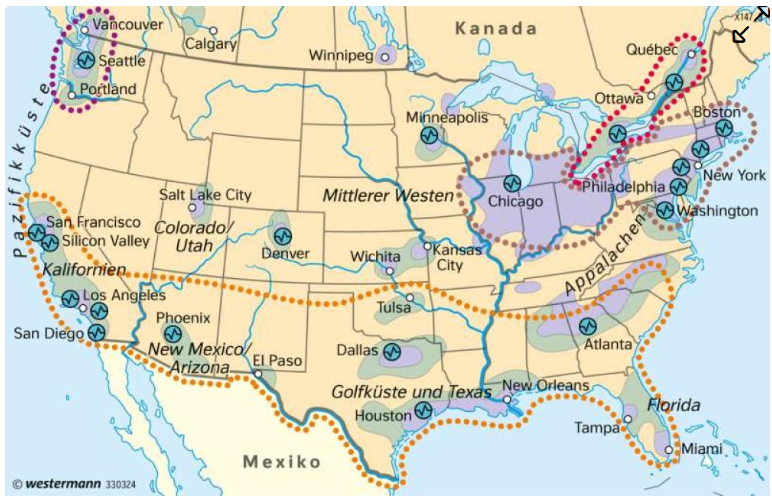

In [76]:
import cv2
from google.colab.patches import cv2_imshow

image_path = '/content/DDM-Project-WS24-25/usa_economic_key_regions.png'
image = cv2.imread(image_path)

cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()

- The Manufacturing Belt around Chicago and Detroit is the largest and oldest industrial region in the U.S., recently impacted by significant structural change.

- The East Coast metropolitan area, from Boston through New York to Washington, is a leading hub for high-tech industries, diverse manufacturing, and major service centers.

- The Portland/Seattle area is known for strong high-tech and aerospace industries, alongside timber processing and paper manufacturing.

- Economic centers in the West include San Francisco and the Silicon Valley (electronics and computer industries) as well as Los Angeles/San Diego (high-tech, heavy and light industries, and services). Together with mining, industrial, high-tech, and service hubs in Phoenix, Dallas, Houston/New Orleans, Atlanta, and Florida, these regions form the Sunbelt, the U.S. economy's growth area.